In [1]:
import pandas as pd
df = pd.read_csv('data.csv', delimiter = ',')
print(df.head(10))


   COOPID   YEAR   MONTH   DAY   PRECIPITATION   MAX TEMP   MIN TEMP  \
0   83163   1931       1     1            1.13       73.0       57.0   
1   83163   1931       1     2            0.20       68.0       48.0   
2   83163   1931       1     3            0.00       72.0       64.0   
3   83163   1931       1     4            0.00       74.0       60.0   
4   83163   1931       1     5            0.00       79.0       68.0   
5   83163   1931       1     6            0.80       80.0       55.0   
6   83163   1931       1     7            0.00       68.0       38.0   
7   83163   1931       1     8            0.00       71.0       52.0   
8   83163   1931       1     9            0.00       77.0       51.0   
9   83163   1931       1    10            0.00       77.0       57.0   

   MEAN TEMP  
0   65.00000  
1   58.00000  
2   68.00000  
3   67.00000  
4   73.50000  
5   67.50000  
6   53.00000  
7   61.50000  
8   64.00000  
9   67.00000  


In [2]:
# labels are not ideal, they start with a space and contains other spaces
print(df.axes)
df.columns = ['id','year','month','day','precipitation',
              'max_temp','min_temp','mean_temp']


[RangeIndex(start=0, stop=31474, step=1), Index(['COOPID', ' YEAR', ' MONTH', ' DAY', ' PRECIPITATION', ' MAX TEMP',
       ' MIN TEMP', ' MEAN TEMP'],
      dtype='object')]


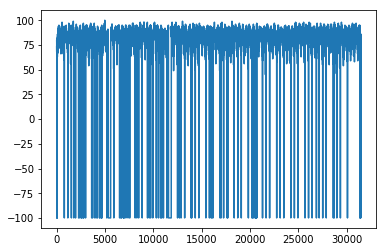

In [3]:
import matplotlib.pyplot as plt
plt.plot(df['max_temp'])
plt.show()

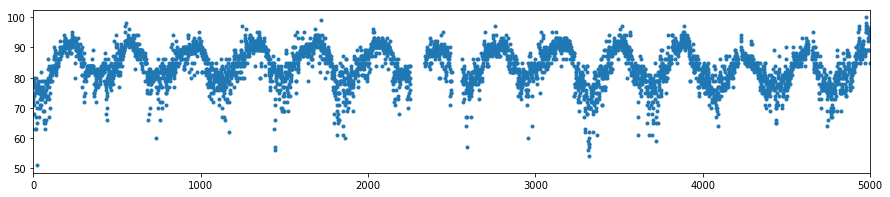

,id,year,month,day,precipitation,max_temp,min_temp,mean_temp
0,83163,1931,1,1,1.13,22.78,13.89,18.33
1,83163,1931,1,2,0.20,20.00,8.89,14.44
2,83163,1931,1,3,0.00,22.22,17.78,20.00
3,83163,1931,1,4,0.00,23.33,15.56,19.44
4,83163,1931,1,5,0.00,26.11,20.00,23.06


In [4]:
# apparently a lot of missing data, coded using unrealistic values -99.9
# also, apparently some values are read as string. not sure why, but need fix

import numpy as np

df.mean_temp = pd.to_numeric(df.mean_temp, errors = 'coerce')
df = df.replace(-99.9, np.nan)

# plt.plot(df.max_temp[:10000], '.')     # standard plot
df.max_temp[:5000].plot(marker = '.',    # pd plot
                        linestyle = 'none',
                        figsize = (15, 3))
plt.show()

# also, convert temperatures to celsius
df.min_temp = round((df.min_temp - 32)/1.8,2)
df.max_temp = round((df.max_temp - 32)/1.8,2)
df.mean_temp = round((df.mean_temp - 32)/1.8,2)

In [5]:
# lets make a function that will clean all my temp data
idx = np.where(df.isnull().any(axis=1) == False)[0][0]
df = df.iloc[idx:,:]

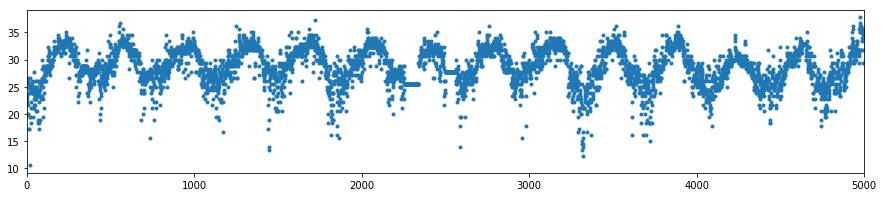

In [6]:
def clean_data(temp):
    y = []
    for i in range(len(temp)):
        if np.isnan(temp.iloc[i]):
            y.append(y[i-1])
        else:
            y.append(temp.iloc[i])
    return pd.Series(y) # no need to cast, but sometimes good to be paranoid
    
df.max_temp  = clean_data(df.max_temp)   
df.min_temp  = clean_data(df.min_temp)   
df.mean_temp = clean_data(df.mean_temp)  
# to check nan are actually replaced: print((df.max_temp.isnull()==True).sum())    

df.max_temp[:5000].plot(marker = '.',    # pd plot
                        linestyle = 'none',
                        figsize = (15, 3))
plt.show()                        

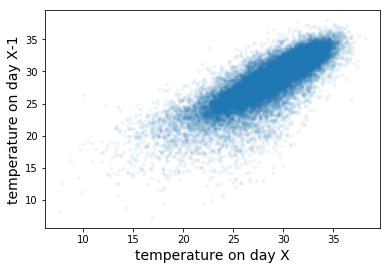

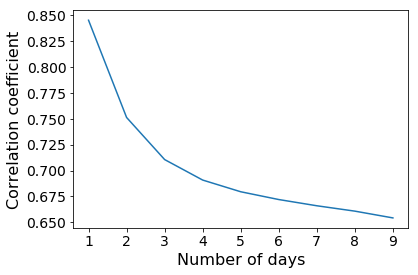

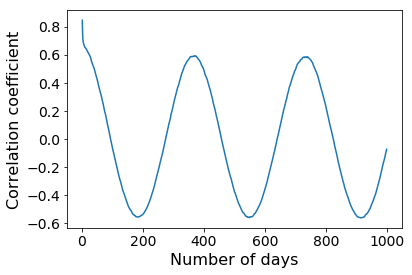

In [7]:
# let's now look at autocorrelation, ie correlation of temparature with itself at as different moment in time
# this is generally usefull with data that are not independent, as often happens with timeseries 
def inspect_autocorrelation(temp, n_days):
    acorr = []
    x = range(1, n_days)
    for shift in x:
        acorr.append( np.corrcoef(temp[:-shift], temp[shift:])[0,1])
    
    plt.plot(x, acorr)
    plt.xlabel('Number of days', fontsize = 16), plt.xticks(size = 14)
    plt.ylabel('Correlation coefficient',fontsize = 16), plt.yticks(size = 14)
    plt.show()

def scatter(x,y):  
    plt.plot(x + np.random.normal(size = x.size, scale = .5),
             y + np.random.normal(size = y.size, scale = .5), 
             '.', alpha = .05)

scatter(df.max_temp[:-1], df.max_temp[1:])
plt.xlabel('temperature on day X', fontsize = 14) 
plt.ylabel('temperature on day X-1', fontsize = 14)
plt.show()

# the further one goes back, the less correlation one can observe, until...
inspect_autocorrelation(df.max_temp, n_days = 10)

# autocorrelation of weather is periodical with period 1 year!
inspect_autocorrelation(df.max_temp, n_days = 1000)


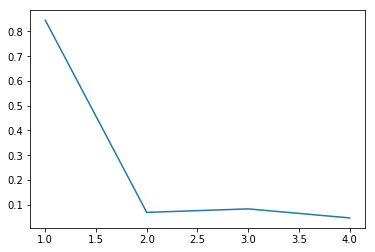

In [8]:
# partial autocorrelation
def partial_autocorrelation(temp):
    # treats data as leftover errors not yet fit
    
    pacorr = []
    x = range(1,5)
    residuals = np.array(temp)
    
    for shift in x:
        pacorr.append(np.corrcoef(temp[:-shift], residuals[shift:])[0,1])

        # linear regression to predict data for the new day
        slope, intercept = np.polyfit(temp[:-shift], residuals[shift:], 1)
        estimate = intercept + slope*temp[:-shift]
        
        # update residuals
        residuals[shift:] = residuals[shift:] - estimate
    
    plt.plot(x,pacorr)
    plt.show()
    
partial_autocorrelation(df.max_temp)


In [9]:
# the annual trend seems a very strong indicator of how the weather is going to be like
# let's see what is left after removing this trend
# one good way would be to fit a periodic function (eg cosine)
# instead, let's look at the median temperatures over all the years, with a 10 day window to smoothen the signal

def  calculate_day_of_year(year, month, day):
    """
    Convert year, month, day to day of the year
    January 1 = 0
    
    parameters
    ----------
    year: int
    month: int
    day: int
    
    Returns
    -------
    day_of_year: int
    """
    
    days_per_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
    if (year % 4) == 0:
        days_per_month[1] = 29 
    
    day_of_year = np.sum(days_per_month[:month-1]) + day - 1
    return day_of_year
    

day_of_year = np.zeros(df.max_temp.size)
for row in range(df.max_temp.size):
    day_of_year[row] = calculate_day_of_year(int(df.iloc[row]['year']),
                                             int(df.iloc[row]['month']),
                                             int(df.iloc[row]['day']))


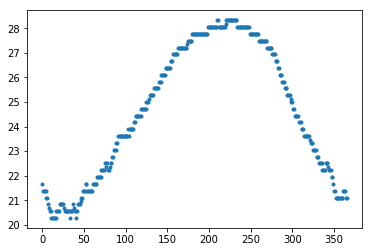

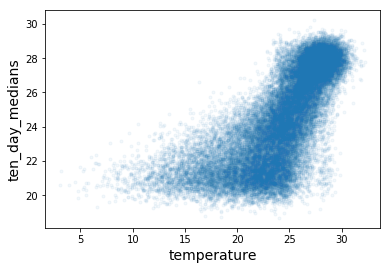

In [10]:
# now, let's find the typical temperature for each day of the year
median_temp_cal = np.zeros(366)

temp = df.mean_temp.copy()
ten_day_medians = np.zeros(temp.size) # just to compare every measure with its overall day  median

for day in range(0,365):
    low_day = max(0, day - 5)
    high_day = min(364, day + 4)
 
    idxs = np.logical_and(day_of_year >= low_day,  day_of_year <= high_day)#[0:20]

    median_temp_cal[day] = np.median(temp.loc[idxs])
    ten_day_medians[np.where(day_of_year == day)] = median_temp_cal[day]
    
    if day == 364:   
        median_temp_cal[365] = np.median(temp.loc[idxs])
        ten_day_medians[np.where(day_of_year == 365)] = median_temp_cal[day]


plt.plot(median_temp_cal,'.') 
plt.show()

scatter(temp, ten_day_medians)
plt.xlabel('temperature', fontsize = 14) 
plt.ylabel('ten_day_medians', fontsize = 14)
plt.show()


In [12]:
# now we can make predicitons based on our temperature calendar
def predict(year, month, day, temperature_calendar):
    doy = calculate_day_of_year(year, month, day)
    prediction = temperature_calendar[doy]
    return prediction

test_year = 2018
test_month = 6
for test_day in range(1,10):
    prediction = predict(test_year, test_month, test_day, median_temp_cal)
    print('predicted temperature for June %d 2018: ' % test_day, prediction) 
#predict(int(df.iloc[row]['year']), int(df.iloc[row]['month']), int(df.iloc[row]['day']))

predicted temperature for June 1 2018:  26.39
predicted temperature for June 2 2018:  26.39
predicted temperature for June 3 2018:  26.39
predicted temperature for June 4 2018:  26.67
predicted temperature for June 5 2018:  26.67
predicted temperature for June 6 2018:  26.67
predicted temperature for June 7 2018:  26.94
predicted temperature for June 8 2018:  26.94
predicted temperature for June 9 2018:  26.94


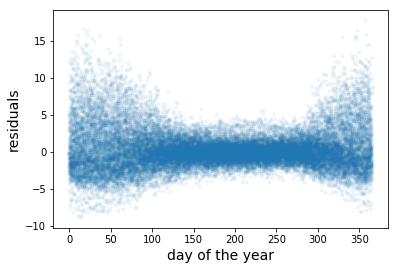

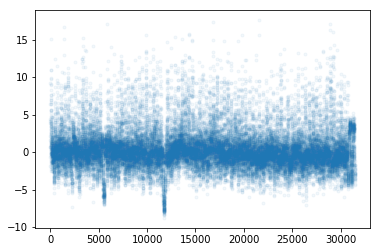

In [13]:
residuals = np.zeros(temp.size)
doy = np.zeros(temp.size)
for i, i_temp in enumerate(temp):
    predicted_temp = predict(int(df.iloc[i]['year']), 
                             int(df.iloc[i]['month']),
                             int(df.iloc[i]['day']),
                             median_temp_cal)
    residuals[i] = predicted_temp - temp.iloc[i]
    doy[i] = calculate_day_of_year(int(df.iloc[i]['year']), int(df.iloc[i]['month']), int(df.iloc[i]['day']))

scatter(doy, residuals)
plt.xlabel('day of the year', fontsize = 14) 
plt.ylabel('residuals', fontsize = 14)
plt.show()
# it appears that the model predicts better in summer than in winter

scatter(np.arange(residuals.size), residuals)
plt.show()
# a few weird observations in the residuals graph, especially for recent years and a couple of thimes in the past
# this looks suspicious to me, will need to re-check the code above

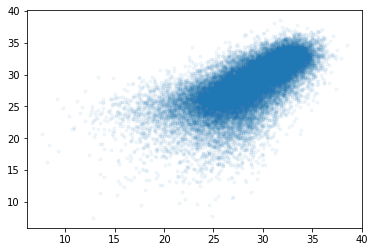

In [19]:
# a good next step toimprove the model further would be to look at autocorrelations
scatter(df.max_temp[:-3], df.max_temp[3:])
plt.show()

# from the plots, there seems to be a (possibly significant) relationship. 
# one could therefore fit a line to the residuals
def get_three_days_coeff(residuals):
    slope, intercept = np.polyfit(residuals[:-3], residuals[3:],1)
    return slope, intercept

slope, intercept = get_three_days_coeff(residuals)
three_day_residuals = residuals[3:] - (intercept + df.max_temp[:-3]*slope)



In [ ]:

# [TODO] ############
# now, predicitions could be made by first computing the deseasonalized temperature, and then adding the three_day model


#####################
